In [139]:
import re

# Initialize empty arrays
time = []
phaseAx = []
phaseBx = []
phaseCx = []
phaseA = []
phaseB = []
phaseC = []
pwmA = []
pwmB = []
pwmC = []  

# Regex pattern
pattern = r"time:\s*(\d+),\s*phaseAx:\s*(-?\d+)\s*,\s*phaseBx:\s*(-?\d+),\s*phaseCx:\s*(-?\d+),\s*phaseA:\s*(\d),\s*phaseB:\s*(\d),\s*phaseC:\s*(\d),\s*pwmA:\s*(\d),\s*pwmB:\s*(\d),\s*pwmC:\s*(\d)"

# Read and parse the file
with open("C:\\Users\\herna\\Downloads\\research\\oscillator\\three_phase_shape.txt", "r") as file:
    for line in file:
        match = re.search(pattern, line)
        if match:
            t, ax, bx, cx, a, b, c, pa, pb, pc = match.groups()
            time.append(int(t))
            phaseAx.append(int(ax))
            phaseBx.append(int(bx))
            phaseCx.append(int(cx))
            phaseA.append(int(a))
            phaseB.append(int(b))
            phaseC.append(int(c))
            pwmA.append(int(pa))
            pwmB.append(int(pb))
            pwmC.append(int(pc))

# Print some results to verify
print("time:", time[:5])
print("pwmA:", pwmA[:5])


time: [0, 5000, 15000, 25000, 35000]
pwmA: [0, 0, 0, 0, 0]


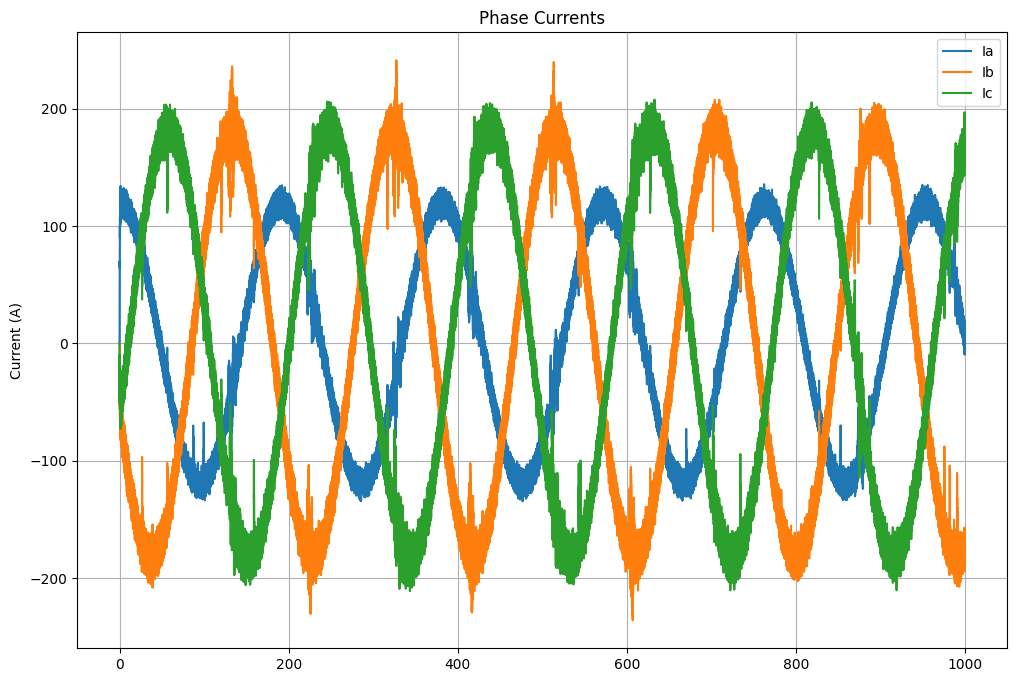

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

R = 1.0                   # Ohm
L = 0.25e-3               # Henry
J = 15.17e-6              # kg·m^2
B = 0.001                 # N·s/m
Ke = 0.02                 # V·s/rad back emf constant = Kt = 1                    # N·m/A  torque constant
Vdc = 240                 # Volts
p = 4                     # poles


time_ns = np.array(time)

time = (time_ns) * 1e-9
dt_array = np.diff(time)

#  Trapezoidal Back-EMF Function 
def trapezoidal_emf(theta):
    theta = theta % (2 * np.pi)
    sector = theta / (np.pi / 3)
    if 0 <= sector < 1:
        return 6 * (sector - 0.5)
    elif 1 <= sector < 2:
        return 1.0
    elif 2 <= sector < 3:
        return 1.0 - 6 * (sector - 2.0)
    elif 3 <= sector < 4:
        return -6 * (sector - 3.5)
    elif 4 <= sector < 5:
        return -1.0
    elif 5 <= sector < 6:
        return -1.0 + 6 * (sector - 5.0)
    else:
        return 0.0

# === Initialize state ===
ia = 0.0
ib = 0.0
theta = 0.0
omega = 0.0

# === Store results ===
ia_log, ib_log, ic_log = [], [], []
omega_log, theta_log, power_log, Te_log,Eab_log,Ebc_log= [], [], [], [], [], []

# === Simulation ===
for i in range(len(dt_array)):
    dt = dt_array[i]
    
    Va = Vdc if phaseA[i] else 0
    Vb = Vdc if phaseB[i] else 0
    Vc = Vdc if phaseC[i] else 0
    
    # Compute line voltages
    Vab = Va - Vb
    Vbc = Vb - Vc
    
    # mechanical and electrical 
    theta_e = theta 
    
    # Back EMFs
    f1 = trapezoidal_emf(theta_e)
    f2 = trapezoidal_emf(theta_e - 2*np.pi/3)
    f3 = trapezoidal_emf(theta_e - 4*np.pi/3)
    Eab = Ke * omega * (f1 - f2)
    Ebc = Ke * omega * (f2 - f3)
    
    # di/dt using coupled equations
    dia = (-R * ia + (2/3)*(Vab - Eab) + (1/3)*(Vbc - Ebc)) / L
    dib = (-R * ib - (1/3)*(Vab - Eab) + (2/3)*(Vbc - Ebc)) / L
    ia += dia * dt
    ib += dib * dt
    ic = -(ia + ib)
    P = Va * ia + Vb * ib + Vc * ic


    # Electrical torque (simplified)
    Te = Ke * (f1 * ia + f2 * ib + f3 * ic) 
    
    # Mechanical equation
    domega = (Te - B * omega) / J
    omega += domega * dt
    theta += omega * dt
    
    # Electrical power per phase

    # Log
    Ebc_log.append(Ebc)
    Eab_log.append(Eab)
    Te_log.append(Te)
    ia_log.append(ia)
    ib_log.append(ib)
    ic_log.append(ic)
    omega_log.append(omega)
    theta_log.append(theta)
    power_log.append(P)

# === PLOTS ===
t_plot = time[:-1]

plt.figure(figsize=(12, 8))

plt.plot(t_plot * 1e3, ia_log, label="Ia")
plt.plot(t_plot * 1e3, ib_log, label="Ib")
plt.plot(t_plot * 1e3, ic_log, label="Ic")
plt.ylabel("Current (A)")
plt.title("Phase Currents")
plt.grid(True)
plt.legend()

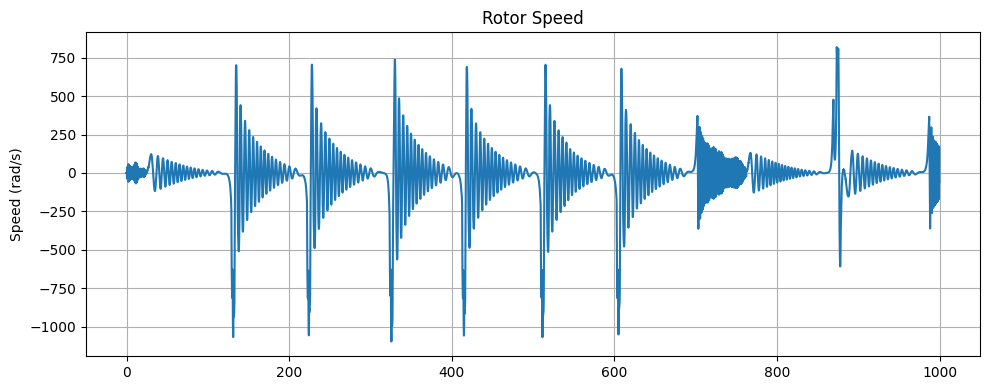

In [141]:
plt.figure(figsize=(10, 4))
plt.plot(t_plot * 1e3, omega_log)
plt.ylabel("Speed (rad/s)")
plt.title("Rotor Speed")
plt.grid(True)

plt.tight_layout()
plt.show()

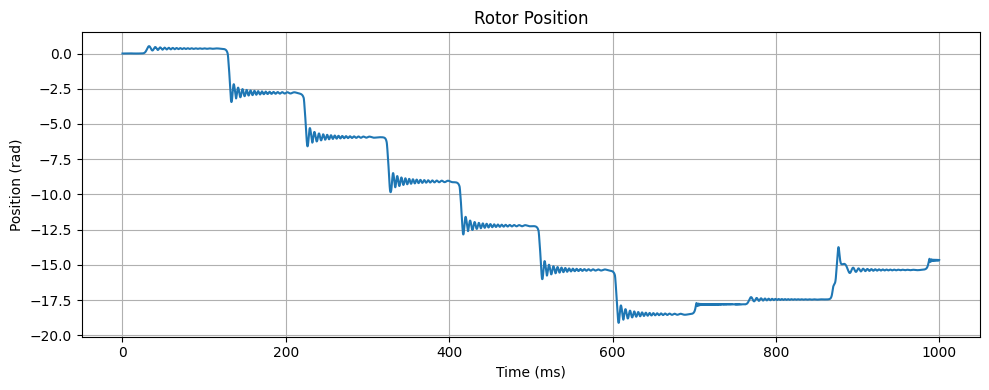

In [142]:
plt.figure(figsize=(10, 4))
plt.plot(t_plot * 1e3, np.unwrap(theta_log))
plt.ylabel("Position (rad)")
plt.xlabel("Time (ms)")
plt.title("Rotor Position")
plt.grid(True)

plt.tight_layout()
plt.show()


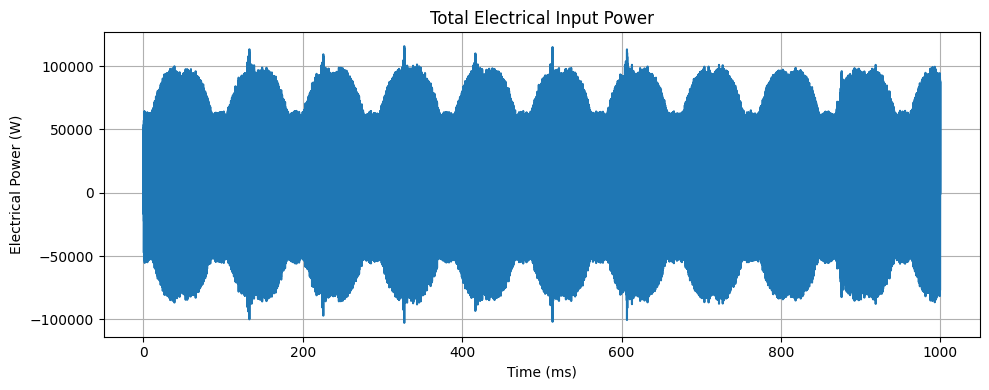

In [143]:
plt.figure(figsize=(10, 4))
plt.plot(t_plot * 1e3, power_log)
plt.xlabel("Time (ms)")
plt.ylabel("Electrical Power (W)")
plt.title("Total Electrical Input Power")
plt.grid(True)
plt.tight_layout()
plt.show()


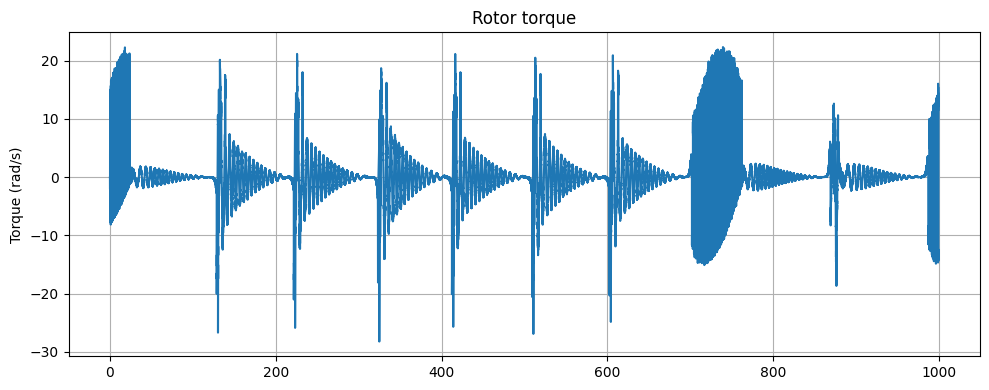

In [144]:
plt.figure(figsize=(10, 4))
plt.plot(t_plot * 1e3, Te_log)
plt.ylabel("Torque (rad/s)")
plt.title("Rotor torque")
plt.grid(True)

plt.tight_layout()
plt.show()